## Segmentation of satellites images using Machine/Deep Learning algorithms

Clarence Lacombe - Corentin Le Guével - Thibault Eschoua - Jérémy Mear - Sunny Raj Mangu

### Pre-processing steps

In [1]:
import os.path
import time
import math
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import listdir
from skimage import exposure
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, jaccard_score, plot_confusion_matrix
Image.MAX_IMAGE_PIXELS = None #to prevent exception using large images, and it is the case for us as we want a lot of DPI

In [2]:
def imagesList (folder):
    """
    Function which get as an input a folder containing RGB images and add all the images of the folder in a list
    Arguments:
    folder -- string containing the folder name where your images are
    
    Returns:
    images -- list of all images that are in the folder
    """
    images=[]
    for filename in listdir(folder):
        img= Image.open(folder+filename).convert('RGB')
        img= np.array(img)               #
        images.append(img)               # Appending all images in 'images' list 
    return images

On charge les données de cartes et des masques associés qui sont dans les dossiers indiqués.

In [3]:
maps = imagesList("NIRRG_Toulouse/")   
masks = imagesList("Masks_Toulouse/")

In [4]:
def resizeImg (img,chopsize):
    """
    Function to sample the image with a different squares images with the chopsize size
    Arguments:
    img -- An image you what to sample with different squares images
    chopsizr -- An integer representing the square size of the sub-images you will create
    
    Returns:
    images_box -- A list containing all the sub square images you got from the input image
    """
    images_box=[]
    width, height, dim = img.shape
    i=0
    for x0 in range(0, width-chopsize, chopsize):
        for y0 in range(0, height-chopsize, chopsize):
            img_crop = img[x0:(x0+chopsize),y0:(y0+chopsize),:]
            images_box.append(img_crop)
    return images_box

def equalizeHist(img, color, channel_id):
    """
    Function to equalize the repartition of color on an image
    Arguments:
    img -- An input image you want to equalize
    color -- A string containing the acronym of the color you are working on
    channel_id -- An integer representing the channel ID on which you will equalize the color
    
    Returns:
    myCropImgMasks -- An image that is equalized
    
    """
    color = ("g")
    channel_ids = (1)
    myCropImgMasks = np.asarray(exposure.equalize_hist(img[:, :, channel_ids]) * 255, dtype='uint8')
    return myCropImgMasks

def imgLabelize(img,ind):
    """
    Function to labellize an image using a threshold. Usefull to create a binary mask from a general mask
    Arguments:
    img -- Image you what to labelize
    ind -- Integer that is a 0 to 255 value to say if you labelize as 0 or 1
    
    Returns:
    img_labelize -- A binary list containing for each pixel a 0/1 value
    """
    width, height= img.shape
    img_labelize = [[0 for i in range(width)] for j in range(height)] 
    for x0 in range(0, width):
        for y0 in range(0, height):  
            if img[x0][y0] > ind:
                img_labelize[x0][y0] = 1
            else :
                img_labelize[x0][y0] = 0
    return img_labelize

Dans l'étape suivante, on récupère l'ensemble des sous-images créées afin d'intégrer le tout dans une seule matrice contenant les données. 
On sauvegarde donc ces deux matrices finales contenant pour l'une l'ensemble des images de satellites et pour l'autre l'ensemble des masques associés.

Attention, la cellule suivante doit juste être lancée une seule fois puisque l'on sauvegarde ces données non pas en mémoire vive mais dans deux fichiers donc l'extension est .npy, qui est un format de fichier permettant de stocker des tableaux numpy en format binaire.

In [ ]:
myMasks = []
myInputMaps = []
for i in range (len(maps)):
    cropMasks = resizeImg(masks[i],160)
    cropMaps = resizeImg(maps[i],160)
    masksConstructor = []
    for j in range (len(cropMasks)):
        equalHistMasks = equalizeHist(cropMasks[j],"g",1)
        labelizeMasks = imgLabelize(equalHistMasks,120)
        masksConstructor.append(labelizeMasks)
    print("DATABASE Progression : ", (i+1) / len(maps) * 100,"%")
    if(i == 0):
        myMasks = masksConstructor
        myInputMaps = cropMaps
        
    else :
        myMasks = np.vstack((myMasks, masksConstructor))
        myInputMaps = np.vstack((myInputMaps, cropMaps))
    
print(np.array(myMasks).shape)
print(np.array(myInputMaps).shape)
#np.save('myMasks_Toulouse', np.array(myMasks))
np.save('myInputMaps_Toulouse_NIRRG', np.array(myInputMaps))

Une fois que l'on a créé les fichiers .npy contenant les données, on peut tout simplement les charger.

In [5]:
myMasks = np.load('myMasks_Toulouse.npy')
myInputMaps = np.load('myInputMaps_Toulouse_NIRRG.npy')
print(np.array(myMasks).shape)
print(np.array(myInputMaps).shape)

(1764, 160, 160)
(1764, 160, 160, 3)


## On créé une metrics et deux loss que l'on pourra utiliser pour notre model

In [6]:
def f1_score(y_true, y_pred):
    """
    Function to compute the f1 score between two arrays
    Arguments:
    y_true -- Array containing the value you want to predict
    y_pred -- Array containing the predicted values
    
    Returns:
    f1_score -- A f1_score pourcentage
    """
    
    y_pred = y_pred[:,:,:,1]
    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    f1_score = (2*intersection) / denominator
    return f1_score

In [38]:
def IoU(y_true, y_pred, smooth = 100):
    y_pred = y_pred[:,:,:,1]
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def IoU_np(y_true,y_pred):
    y_pred = y_pred[:,:,:,1]
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice_coef(y_true, y_pred, smooth = 100):
    y_pred = y_pred[:,:,:,1]
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy_test(y_true, y_pred):
    y_pred = y_pred[:,:,:,1]
    return K.mean(K.equal(y_true, K.round(y_pred)))

## U-Net Model

Maintenant que l'on a chargé les données on créé notre model et et l'instancie.

In [10]:
def unet_model(n_classes=2, im_sz=160, n_channels=3, n_filters_start=32, growth_factor=2, upconv=True):
    """
    U-Net function to compute the U-Net Model
    Arguments:
    n_classes -- The number of classes we want to find on our data. Here it is Tree or not Tree so we just do
    binary segmentation
    im_sz -- The image size you are using
    n_channels -- The number of channel of your images. Can be 3 for RGB or more for images with bands
    n_filters_start -- The number of filters to start with
    growth_factor -- ??
    upconv -- ??
    
    Return:
    model -- the model
    
    """
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    metrics = ['accuracy']

    model.compile(optimizer=opt, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=metrics)
    return model

In [11]:
model = unet_model()

We can just now start the training using the parameters below.

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 150
#TRAIN_SZ = 4000 # train size
#myMasks = myMasks[:TRAIN_SZ,:,:]
#myInputMaps = myInputMaps[:TRAIN_SZ,:,:,:]

X_train, X_test, y_train, y_test = train_test_split(myInputMaps, myMasks, train_size=0.7, random_state=42)

print(np.array(X_train).shape)
print(np.array(y_train).shape)
print(np.array(X_test).shape)
print(np.array(y_test).shape)

weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights.hdf5'
model = unet_model()
model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('log_unet.csv', append=True, separator=';')
tensorboard = TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          verbose=2, shuffle=True,
          callbacks=[model_checkpoint, csv_logger, tensorboard],
          validation_data=(X_test, y_test))

(1234, 160, 160, 3)
(1234, 160, 160)
(530, 160, 160, 3)
(530, 160, 160)
Epoch 1/3


After training, we plot the metrics we have from the model to see how it goes and if it is overfitting for example.

In [ ]:
print(model.history.history.keys())  

plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(model.history.history['accuracy'])  
plt.plot(model.history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(model.history.history['loss'])  
plt.plot(model.history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

model.save('test.h5')

## Prediction on the image using the model

In [12]:
def predict(x, model, patch_sz=160, n_classes=2):
    """
    Function to predic an imput using the model you should have trained before
    Arguments:
    x -- the input you want to predict. It can be anything but in our case it is an image
    model -- the model you trained
    patch_sz -- ?
    n_classes -- the number of class we want to predict. In our use case two for trees and non-trees
    
    Returns:
    prediction --
        
    """
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]
    # make extended img so that it contains integer number of patches
    npatches_vertical = math.ceil(img_height / patch_sz)
    npatches_horizontal = math.ceil(img_width / patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    # fill extended image with mirrors:
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[:, 2 * img_width - j - 1, :]

    # now we assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i * patch_sz, (i + 1) * patch_sz
            y0, y1 = j * patch_sz, (j + 1) * patch_sz
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    # model.predict() needs numpy array rather than a list
    patches_array = np.asarray(patches_list)
    # predictions:
    patches_predict = model.predict(patches_array, batch_size=4)
    prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * patch_sz, (i + 1) * patch_sz
        y0, y1 = j * patch_sz, (j + 1) * patch_sz
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]

def picture_from_mask(mask, threshold=0):
    """
    Function to create image from the mask you've got
    Arguments:
    mask -- The binary mask you've got
    threshold -- ?
    
    Returns:
    pict -- A RGB picture ?
    
    """
    colors = {
        0: [27, 120, 55]    # Trees
    }
    z_order = {
        0: 0
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    cl = z_order[0]
    for ch in range(len(colors[0])):
        pict[ch,:,:][mask[1,:,:] <= threshold] = colors[cl][ch]
      
    return pict

In [33]:
def predict_img(img_rgb,predict_img,model,PATCH_SZ, N_CLASSES,color_delta,threshold=0):
    mask = np.zeros(shape=(predict_img.shape[0], predict_img.shape[1]), dtype=np.uint8)
    width, height, dim = predict_img.shape
    chopsize = 160
    for x0 in range(0, width, chopsize):
        if (x0+chopsize) <= width :
            for y0 in range(0, height, chopsize):
                if (y0+chopsize) <= height :
                    img_pred = predict(predict_img[x0:(x0+chopsize),y0:(y0+chopsize),:], model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
                    map = picture_from_mask(img_pred, threshold)
                    for dimension in range(dim):
                        img_rgb[x0:(x0+chopsize),y0:(y0+chopsize), dimension] = np.clip(img_rgb[x0:(x0+chopsize),y0:(y0+chopsize), dimension] + color_delta[dimension] * (map[0][:, :] / 255), 0, 255)
                    
                    
                    mask[x0:(x0+chopsize),y0:(y0+chopsize)][img_pred[1,:,:]<=threshold] = 1
                        
                else:
                    img_pred = predict(predict_img[x0:(x0+chopsize),y0:height,:], model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
                    map = picture_from_mask(img_pred, threshold)    
                    for dimension in range(dim):
                        img_rgb[x0:(x0+chopsize),y0:height, dimension] = np.clip(img_rgb[x0:(x0+chopsize),y0:height, dimension] + color_delta[dimension] * (map[0][:, :] / 255), 0, 255)
                    
                    mask[x0:(x0+chopsize),y0:height][img_pred[1,:,:]<=threshold] = 1

        else:
            for y0 in range(0,height,chopsize):
                img_pred = predict(predict_img[x0:width,y0:(y0+chopsize),:], model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
                map = picture_from_mask(img_pred, threshold)    
                for dimension in range(dim):
                    img_rgb[x0:width,y0:(y0+chopsize), dimension] = np.clip(img_rgb[x0:width,y0:(y0+chopsize), dimension] + color_delta[dimension] * (map[0][:, :] / 255), 0, 255)
                
                mask[x0:width,y0:(y0+chopsize)][img_pred[1,:,:]<=threshold] = 1
        
    return [img_rgb,mask]

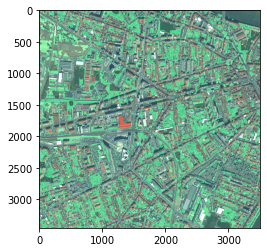

In [35]:
maps_rgb = imagesList("Map_Toulouse_RGB/")
maps = imagesList("NIRRG_Toulouse/")   
model2 = load_model('model2.h5')
PATCH_SZ = 160
N_CLASSES = 2
color_delta=[27, 120, 55]

img_predict = predict_img(maps_rgb[2],maps[2],model2,PATCH_SZ, N_CLASSES,color_delta,0.4)
plt.imshow(img_predict[0])

In [18]:
im_test = Image.fromarray(img_predict)
im_test.save("Best.tiff")

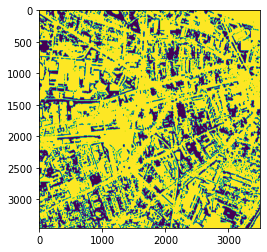

In [36]:
plt.imshow(img_predict[1])

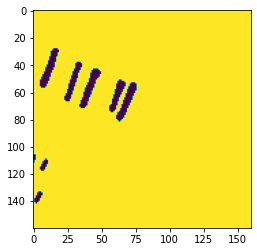

In [37]:
plt.imshow(myMasks[2])

In [ ]:
imgLabelize(equalHistMasks,120)